# Class Imbalance Problems - Lab

## Introduction


Now that you've gone over some techniques for tuning classification models on imbalanced datasets, it's time to practice those techniques. In this lab, you'll investigate credit card fraud and attempt to tune a model to flag suspicious activity.

## Objectives

You will be able to:

- Use sampling techniques to address a class imbalance problem within a dataset 
- Create a visualization of ROC curves and use it to assess a model

## Predicting credit card fraud


The following cell loads all the functions you will be using in this lab. All you need to do is run it is the following. (N.B. You made need to pip/conda install `imbalanced-learn`.)

In [20]:
import pandas as pd
import numpy as np
import itertools

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE, ADASYN

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Use Pandas to load the compressed CSV file, `'creditcard.csv.gz'`. 

> Note: You need to pass an additional argument (`compression='gzip'`) to read_csv() in order to load compressed CSV files. 

In [2]:
# Load a compressed csv file
df = pd.read_csv('creditcard.csv.gz', compression='gzip')

# Print the first five rows of data
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## Preview the class imbalance

Did you notice that the dataset has 31 columns? The first is a time field followed by columns V1 - V28, created by way of manual feature engineering done on the backend that we have little information about. Finally, there's the amount of the purchase and a binary `'Class'` flag. This last column, `'Class'`, is the indication of whether or not the purchase was fraudulent, and it is what you should be attempting to predict.

Take a look at how imbalanced this dataset is: 

In [9]:
# Count the number of fraudulent/infraudulent purchases
class_counts= df['Class'].value_counts()
print (class_counts)


0    284315
1       492
Name: Class, dtype: int64


In [10]:
print('fraudulent purchases: \n')
print(df['Class'].value_counts())
print('-----------------------------------')
print('infraudulent purchases: \n')
print(df['Class'].value_counts(normalize=True))

fraudulent purchases: 

0    284315
1       492
Name: Class, dtype: int64
-----------------------------------
infraudulent purchases: 

0    0.998273
1    0.001727
Name: Class, dtype: float64


## Define the predictor and target variables

Define `X` and `y` and perform a standard train-test split. Assign 25% to the test set and `random_state` to 0. 

In [12]:
# Your code here
y = df['Class']
X = df.drop(columns=['Class'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (213605, 30) (213605,)
Test set shape: (71202, 30) (71202,)


Find the class imbalance in the training and test sets: 

In [13]:
# Calculate and display class imbalance in the training set
print("Training set class distribution (percentages):")
print(y_train.value_counts(normalize=True) * 100)
print('\n')  # Add a blank line for separation

# Calculate and display class imbalance in the test set
print("Test set class distribution (percentages):")
print(y_test.value_counts(normalize=True) * 100)


Training set class distribution (percentages):
0    99.825847
1     0.174153
Name: Class, dtype: float64


Test set class distribution (percentages):
0    99.831465
1     0.168535
Name: Class, dtype: float64


## Create an initial model

As a baseline, train a vanilla logistic regression model. Then plot the ROC curve and print out the AUC. We'll use this as a comparison for how our future models perform.

AUC: 0.9280


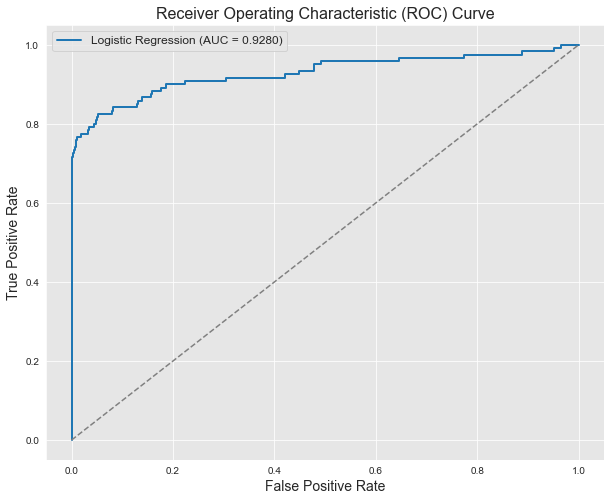

In [15]:
# Initial Model
logreg = LogisticRegression(solver='liblinear', random_state=0)  # Simple solver for small datasets
logreg.fit(X_train, y_train)  # Train logistic regression model

# Probability scores for the positive class
y_score = logreg.predict_proba(X_test)[:, 1]

# Compute false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Compute AUC
auc_value = auc(fpr, tpr)
print(f"AUC: {auc_value:.4f}")

# Seaborn styling
sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"Logistic Regression (AUC = {auc_value:.4f})", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Diagonal line for random performance
plt.xlabel("False Positive Rate", fontsize=14)
plt.ylabel("True Positive Rate", fontsize=14)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


Use the `pred` function on the test set and name the predictions `pred`.

In [16]:
# Pred
# Make predictions on the test set
pred = logreg.predict(X_test)

# Display the first few predictions
print("Predictions on the test set:")
print(pred[:10])  # Display the first 10 predictions for reference


Predictions on the test set:
[0 0 0 0 0 0 0 0 0 0]


Use scikit-learn's `ConfusionMatrixDisplay` function to plot the confusion matrix of the test set: 

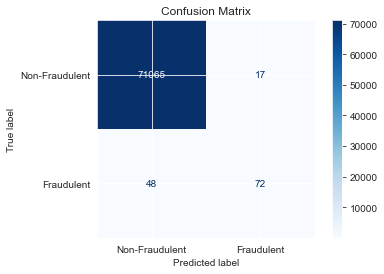

In [17]:
# Plot confusion matrix of the test set 
# Calculate the confusion matrix
cm = confusion_matrix(y_test, pred)

# Create and plot the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Fraudulent', 'Fraudulent'])
disp.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())

# Display the plot
plt.title("Confusion Matrix")
plt.show()


## Tune the model 

Try some of the various techniques proposed to tune your model. Compare your models using AUC and ROC curve.

LogisticRegression(C=0.001, random_state=0, solver='liblinear')
AUC for C=0.001: 0.8609
-------------------------------------------------------
LogisticRegression(C=0.01, random_state=0, solver='liblinear')
AUC for C=0.01: 0.9192
-------------------------------------------------------
LogisticRegression(C=0.1, random_state=0, solver='liblinear')
AUC for C=0.1: 0.9287
-------------------------------------------------------
LogisticRegression(C=1, random_state=0, solver='liblinear')
AUC for C=1: 0.9280
-------------------------------------------------------
LogisticRegression(C=10, random_state=0, solver='liblinear')
AUC for C=10: 0.9282
-------------------------------------------------------
LogisticRegression(C=100, random_state=0, solver='liblinear')
AUC for C=100: 0.9284
-------------------------------------------------------


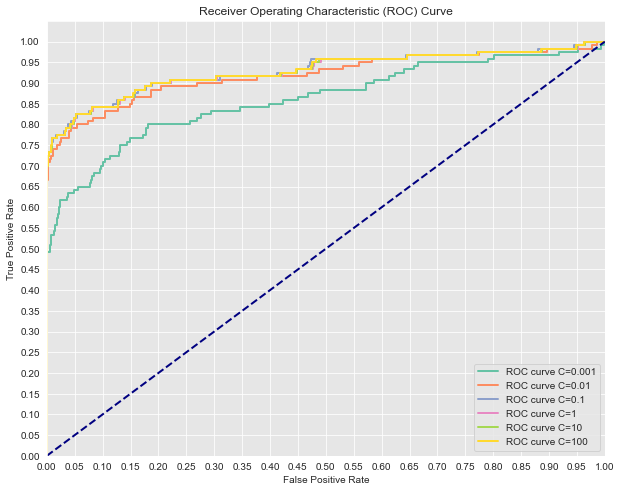

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Define the range of C values for regularization
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

# Set up the plot
plt.figure(figsize=(10, 8))

# Loop through each C value and train the logistic regression model
for n, c in enumerate(C_param_range):
    # Initialize and train the model with the current C value
    logreg = LogisticRegression(C=c, solver='liblinear', random_state=0)
    model_log = logreg.fit(X_train, y_train)  # Fit the model on the training data
    
    print(model_log)  # Preview model parameters

    # Predict the probabilities for the test set
    y_score = model_log.predict_proba(X_test)[:, 1]  # Get the probability for class 1 (fraudulent)

    # Compute the false positive rate and true positive rate for ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    # Calculate AUC and print it
    print(f'AUC for C={names[n]}: {auc(fpr, tpr):.4f}')
    print('-------------------------------------------------------')
    
    # Plot the ROC curve for this regularization strength
    lw = 2
    plt.plot(fpr, tpr, color=colors[n], lw=lw, label=f'ROC curve C={names[n]}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# Set the axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.001, 0.01, 0.1, 1, 10, 100]
names = [0.001, 0.01, 0.1, 1, 10, 100]
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = None
    model_log = None
    print(model_log) # Preview model params

    # Predict
    y_hat_test = None

    y_score = None

    fpr, tpr, thresholds = None
    
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    print('-------------------------------------------------------')
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

### SMOTE

Use the `SMOTE` class from the `imblearn` package in order to improve the model's performance on the minority class. 

In [22]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Previous original class distribution
print("Original class distribution in training data:")
print(y_train.value_counts())

# Fit SMOTE to the training data
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Preview synthetic sample class distribution
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())


Original class distribution in training data:
0    213233
1       372
Name: Class, dtype: int64

Class distribution after SMOTE:
1    213233
0    213233
Name: Class, dtype: int64


In [23]:
# Previous original class distribution
print(y_train.value_counts())

# Fit SMOTE to training data
smote= SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Preview synthetic sample class distribution
print('\n')
print(pd.Series(y_train_resampled).value_counts()) 

0    213233
1       372
Name: Class, dtype: int64


1    213233
0    213233
Name: Class, dtype: int64


Similar to what you did above, build models with this resampled training data: 

AUC for C=0.005: 0.9925
-------------------------------------------------------
AUC for C=0.1: 0.9925
-------------------------------------------------------
AUC for C=0.2: 0.9925
-------------------------------------------------------
AUC for C=0.5: 0.9925
-------------------------------------------------------
AUC for C=0.8: 0.9925
-------------------------------------------------------
AUC for C=1: 0.9925
-------------------------------------------------------
AUC for C=1.25: 0.9925
-------------------------------------------------------
AUC for C=1.5: 0.9925
-------------------------------------------------------
AUC for C=2: 0.9925
-------------------------------------------------------


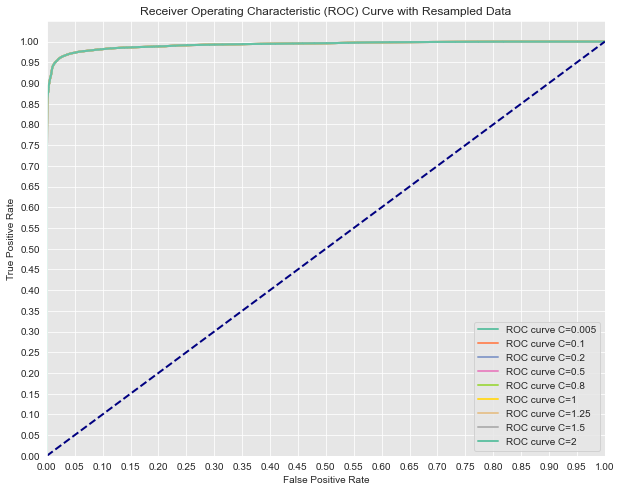

In [28]:
# Define the range of C values for regularization
C_param_range = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
names = [0.005, 0.1, 0.2, 0.5, 0.8, 1, 1.25, 1.5, 2]
colors = sns.color_palette('Set2', n_colors=len(names))

# Set up the plot
plt.figure(figsize=(10, 8))

# Loop through each C value and train the logistic regression model
for n, c in enumerate(C_param_range):
    # Initialize and train the model with the current C value
    logreg = LogisticRegression(C=c, solver='liblinear', random_state=0)
    model_log = logreg.fit(X_train_resampled, y_train_resampled)  # Fit on the resampled data
    
    # Predict the probabilities for the test set
    y_score = model_log.predict_proba(X_test)[:, 1]  # Get the probability for class 1 (fraudulent)

    # Compute the false positive rate and true positive rate for the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    # Calculate AUC and print it
    auc_value = auc(fpr, tpr)
    print(f'AUC for C={names[n]}: {auc_value:.4f}')
    print('-------------------------------------------------------')
    
    # Plot the ROC curve for this regularization strength
    lw = 2
    plt.plot(fpr, tpr, color=colors[n], lw=lw, label=f'ROC curve C={names[n]}')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

# Set the axis limits and labels
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with Resampled Data')
plt.legend(loc='lower right')
plt.show()


## Something wrong here? 
Describe what is misleading about the AUC score and ROC curves produced by this code:

0    284315
1       492
Name: Class, dtype: int64
---------------------------------
1    284315
0    284315
Name: Class, dtype: int64
----------------------------------------------
AUC for 0.005: 0.9933566109166896
----------------------------------------------
AUC for 0.1: 0.9933599696684429
----------------------------------------------
AUC for 0.2: 0.9933599364154346
----------------------------------------------
AUC for 0.3: 0.9933599027665574
----------------------------------------------
AUC for 0.5: 0.9933599053397069
----------------------------------------------
AUC for 0.6: 0.9933599031624266
----------------------------------------------
AUC for 0.7: 0.9933599073190527
----------------------------------------------
AUC for 0.8: 0.9933599041520995


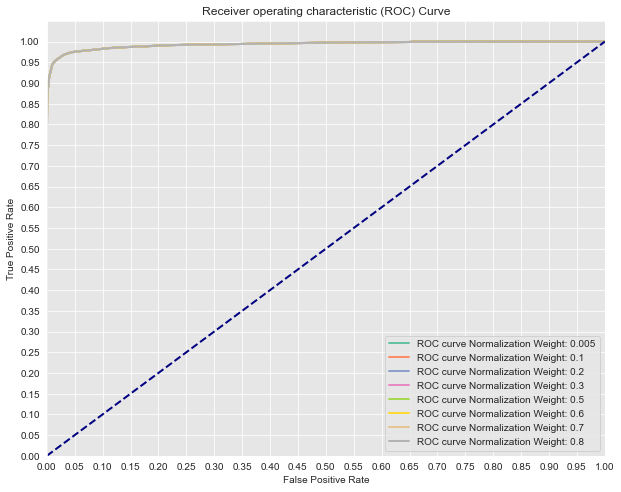

In [29]:
# Previous original class distribution
print(y.value_counts()) 
X_resampled, y_resampled = SMOTE().fit_resample(X, y) 
# Preview synthetic sample class distribution
print('---------------------------------')
print(pd.Series(y_resampled).value_counts()) 

# Split resampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

# Now let's compare a few different regularization performances on the dataset:
C_param_range = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8]
names = [0.005, 0.1, 0.2, 0.3, 0.5, 0.6, 0.7, 0.8, 0.9]
colors = sns.color_palette('Set2', n_colors=len(names))

plt.figure(figsize=(10, 8))

for n, c in enumerate(C_param_range):
    # Fit a model
    logreg = LogisticRegression(fit_intercept=False, C=c, solver='liblinear')
    model_log = logreg.fit(X_train, y_train)

    # Predict
    y_hat_test = logreg.predict(X_test)

    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    print('----------------------------------------------')
    print('AUC for {}: {}'.format(names[n], auc(fpr, tpr)))
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve Normalization Weight: {}'.format(names[n]))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Your response here

Fit the model only once: Remove the second call to fit() and use the fitted model to make predictions.
Correct the mismatch between C_param_range and names: Ensure both lists have the same length.
Evaluate on the original test set: Use the original, imbalanced test set to evaluate performance rather than the resampled data.

## Summary

In this lab, you got some hands-on practice tuning logistic regression models. In the upcoming labs and lessons, you will continue to dig into the underlying mathematics of logistic regression, taking on a statistical point of view and providing you with a deeper understanding of how the algorithm works. This should give you further insight as to how to tune and apply these models going forward.